## Vision Transformer
我们以原文中的一张图，来快速了解ViT这个模型，我们把整体结构分成五个部分：

- 将输入的图像进行patch的划分
- Linear Projection of Flatted Patches，将patch拉平并进行线性映射
- 生成CLS token特殊字符*，生成Position Embedding，Patch+Position Embedding相加作为inputs token
- Transformer Encoder编码，特征提取
- MLP Head进行分类输出结果

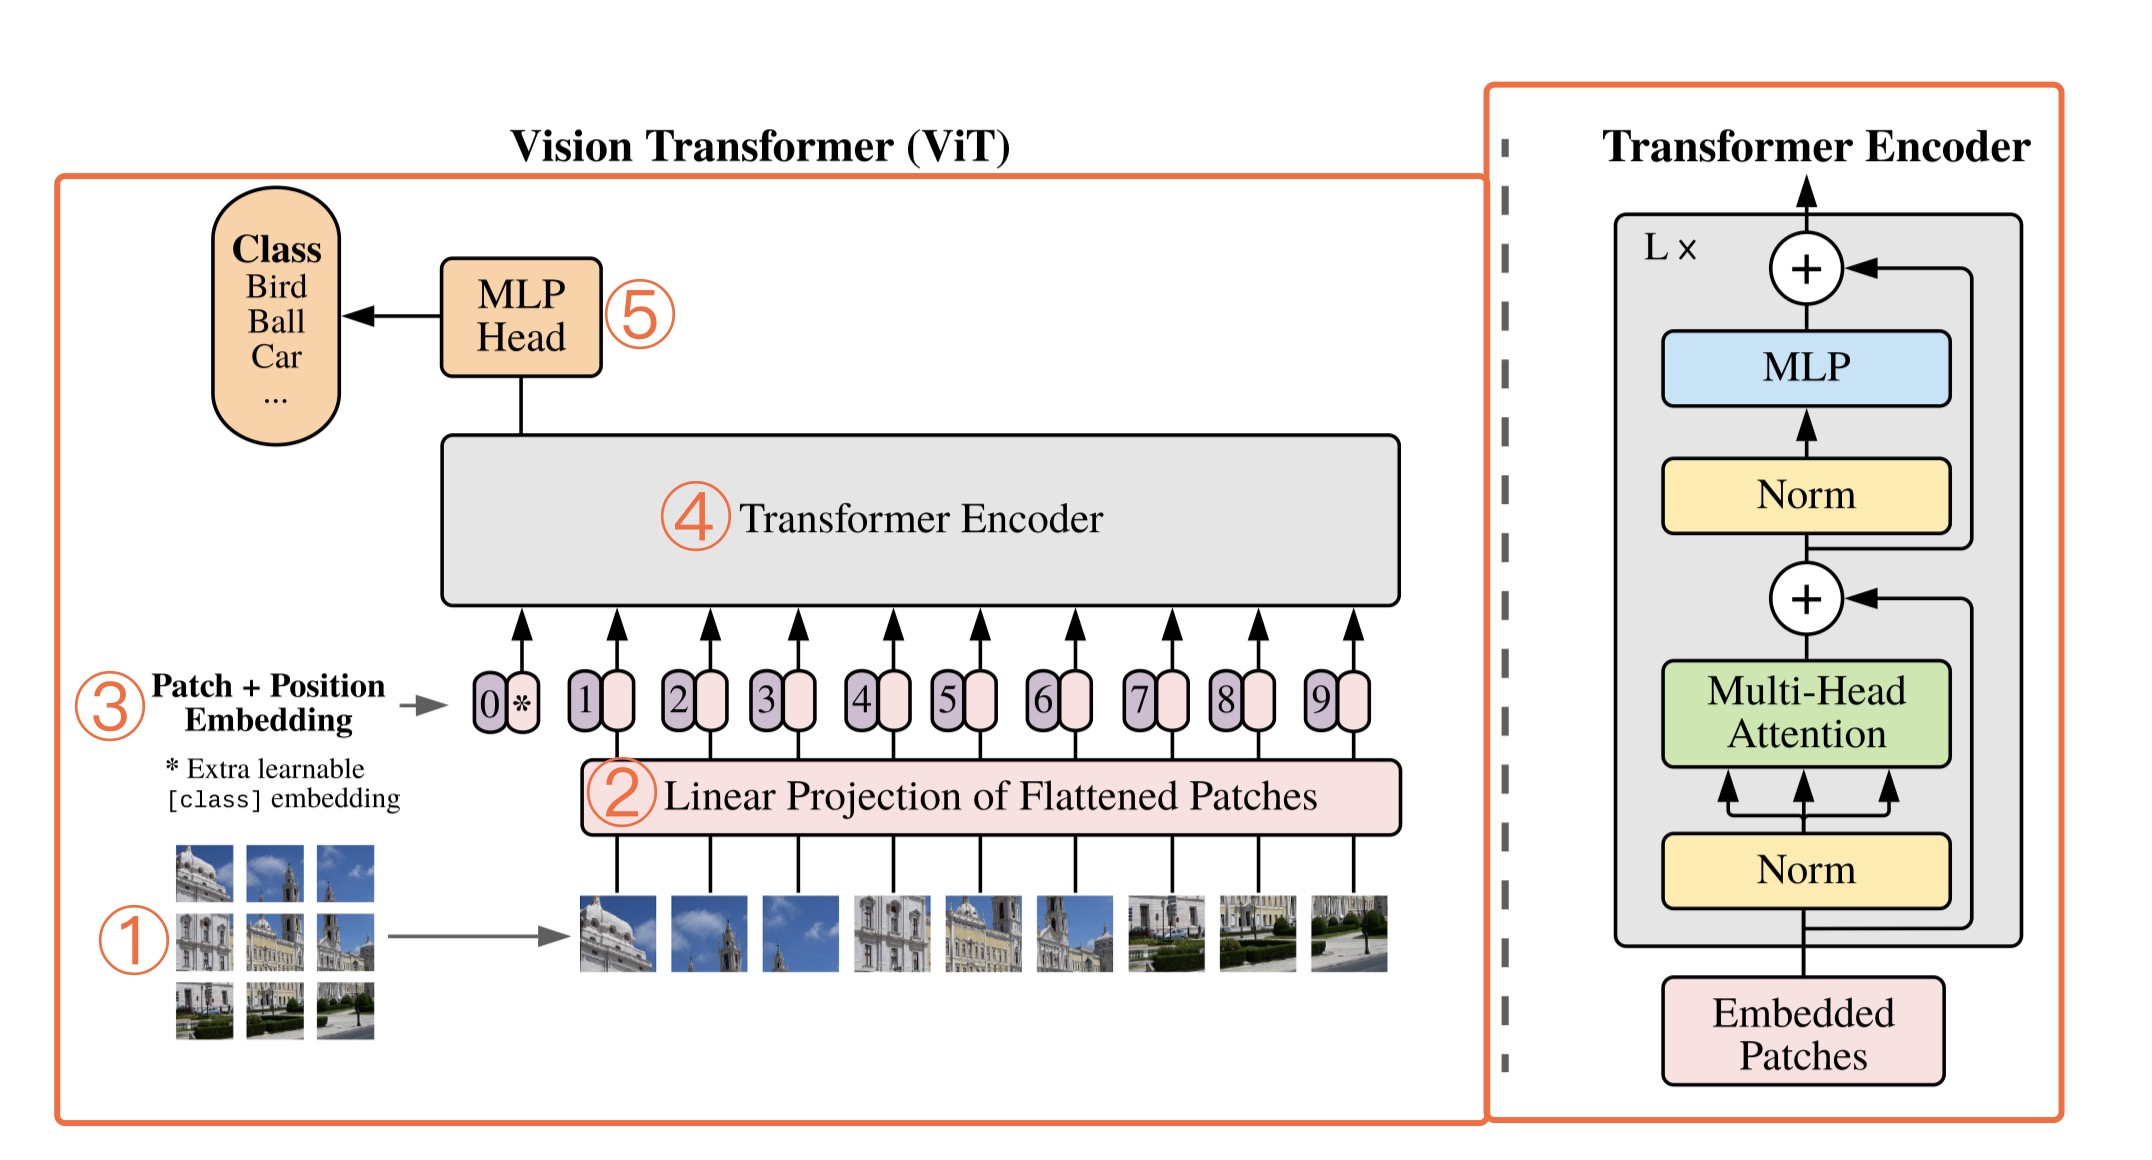

### 第一部分：图像划分Patch

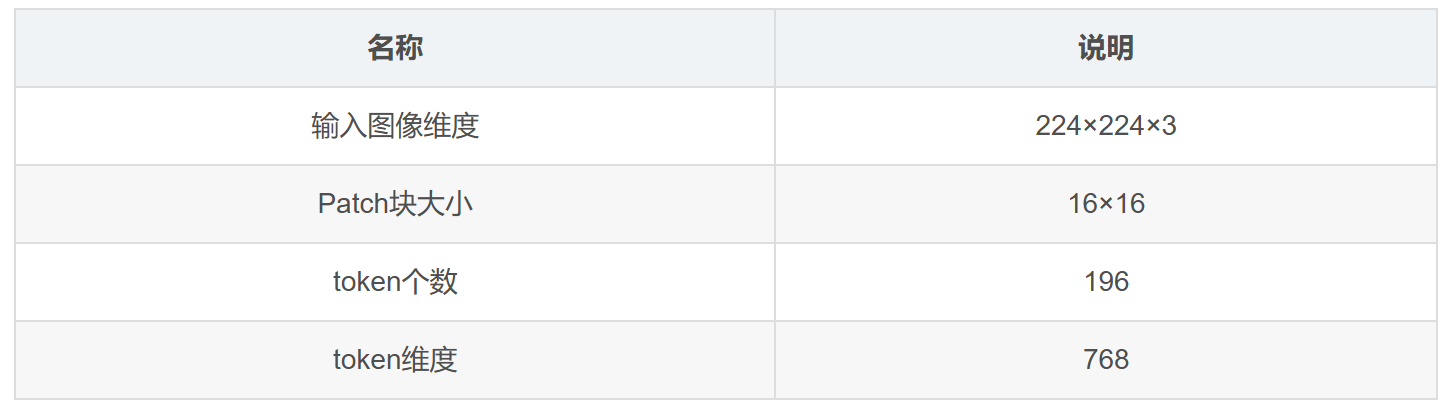

将图像分成16×16的patch(小方块)，每个patch块可以看做是一个token(词向量)，共有（224/16=14）14×14=196个token，每个token的维度为16×16×3=768

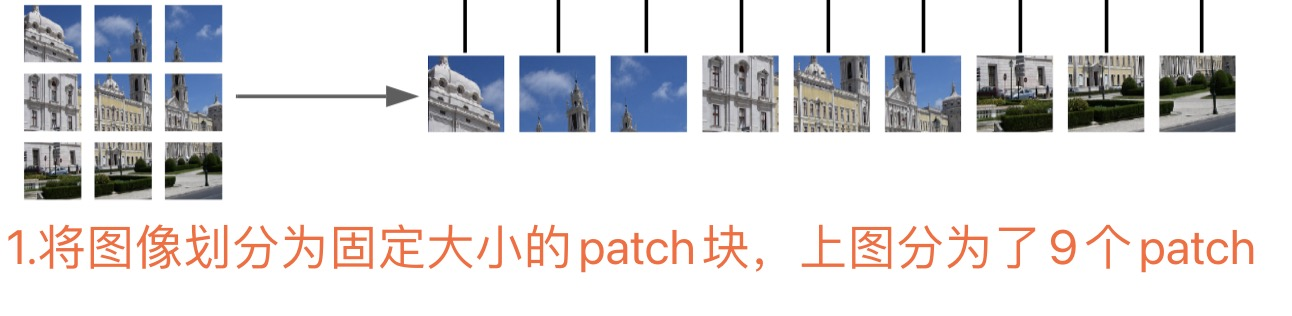

### 第二部分：Linear Projection of Flatted Patches
一个patch块它的维度是16×16×3=768，我们把它flatten拉平成行向量它的长度就为768，一共有14×14=196个patch，所以输入的维度是[196, 768]，我们经过一个Linear Projection（映射）到指定的维度，比如1024或2048，我们用全连接层来实现，但映射的维度我们任然选择为768，那么此时的输出是[196, 768]。
整个过程我们把它称作patch embedding；输出的结果维度是[196, 768]


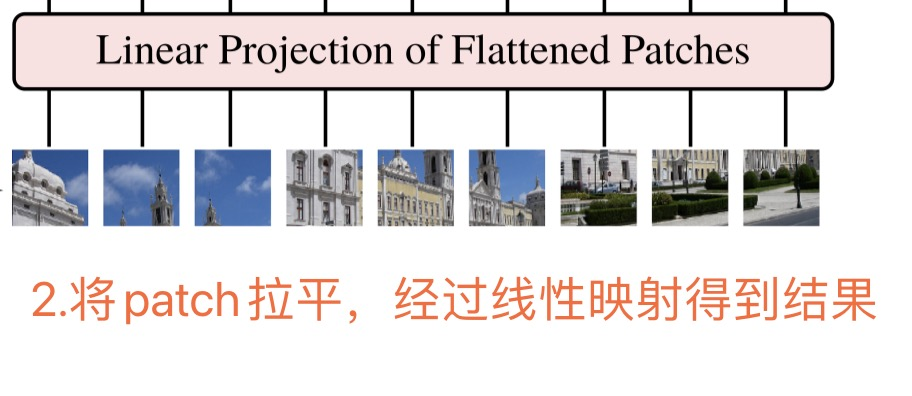

但是有大佬就不服啦，反正都是线性映射，为啥我要这么复杂，把它flatten后在用全连接层呢？聪明的大佬就想到，我直接使用卷积来实现，用16×16大小的卷积核，步长stride=16，维度设为768，输入[3, 224, 224]->[768, 14, 14]，然后交换并合并一下维度不就得到结果了吗？[196, 768]

### 第三部分：Patch+Position Embedding
patch embedding的维度为[196, 768]

- 首先生成一个cls token它的维度为[1, 768]，然后拼接到输入的path embedding，得到的维度为[197, 768]
- 对197个patch都生成一个位置信息，它的维度同patch维度为[197, 768]
- Patch+Position Embedding，直接相加为新的的token作为encoder的输入


cls token和位置信息编码是如何来的呢？随机生成的可学习参数，可以全零初始化，也可以0-1随机初始化

In [ ]:
import torch
import torch.nn as nn


cls_token = nn.Parameter(torch.zeros(1, 768))
pos_embedding = nn.Parameter(torch.zeros(197, 768))

- cls token的作用是为了同NLP领域的Transformer保持一致，最后直接提取cls token作为网络提取得到的特征，作为类别预测的输出，放入MLP进行分类

- 不使用cls token也是可以的，对196个维度为768的patch进行全局均值池化，得到结果维度为[196，1]后作为类别预测的输出，放入MPL进行分类

- 通过学习率的调整可以让cls token和对patch全局均值池化两种方法获得相近似的结果，但为尽可能接近原始Transformer模型，选择使用额外的cls标记

- 位置信息编码是为了给patch加上相对位置，不然在后面的特征提取中丢掉位置信息可就不好了

- 位置信息编码被用于增加patch embedding的原始位置信息

- 位置信息编码有可学习参数类型，有通过公式计算的方法，可以是一维、二维；但不使用性能会差点

- 没有位置编码性能差距会很大，但选择不同位置编码几乎没有差异，原因是Transformer是直接在patch上操作而不是基于像素级，因此，空间信息编码方式差异没那么重要


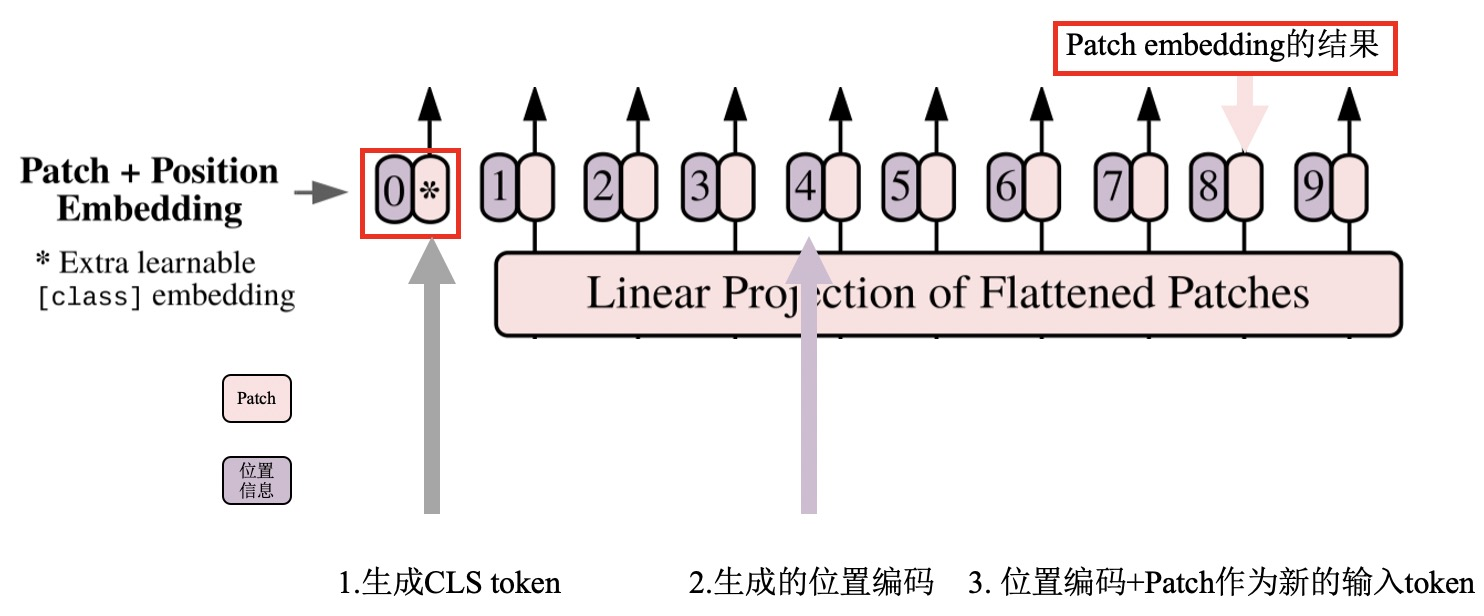

### 第四部分：Transformer Encoder
整个Transformer Encoder结构如下，详细代码实现和Multi-Head Attention的理解请看开头的视频讲解。

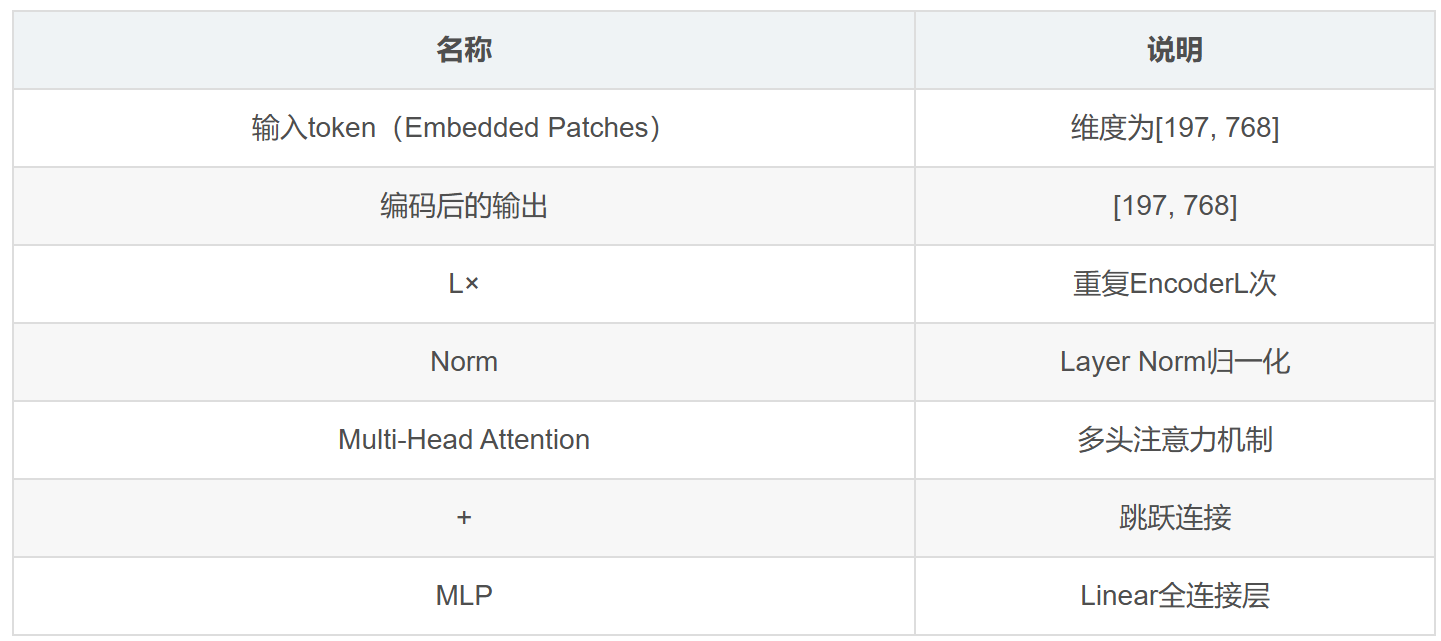

Transformer Encoder网络结构如下：

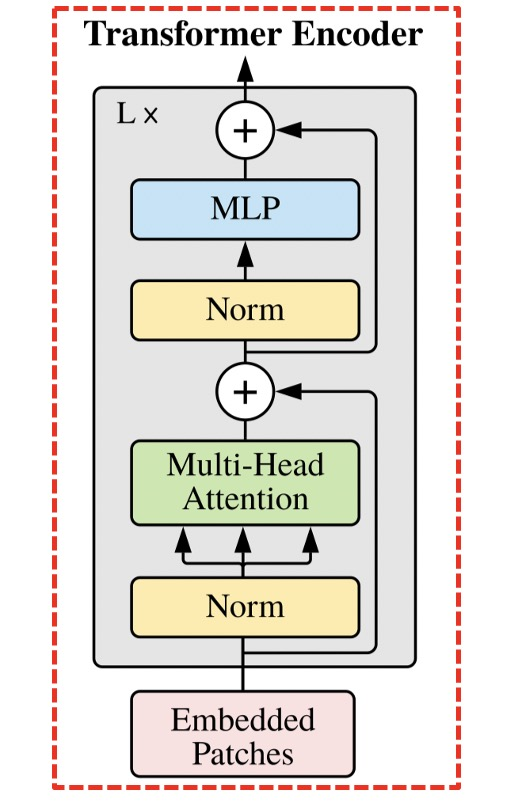

Encoder输入的维度为[197, 768]，输出的维度为[197, 768]，可以把中间过程简单的理解成为特征提取的过程
其中的Multi-Head Attention多头注意力机制，看完开头 太阳花的小绿豆的博客后，做一个简单的认识：

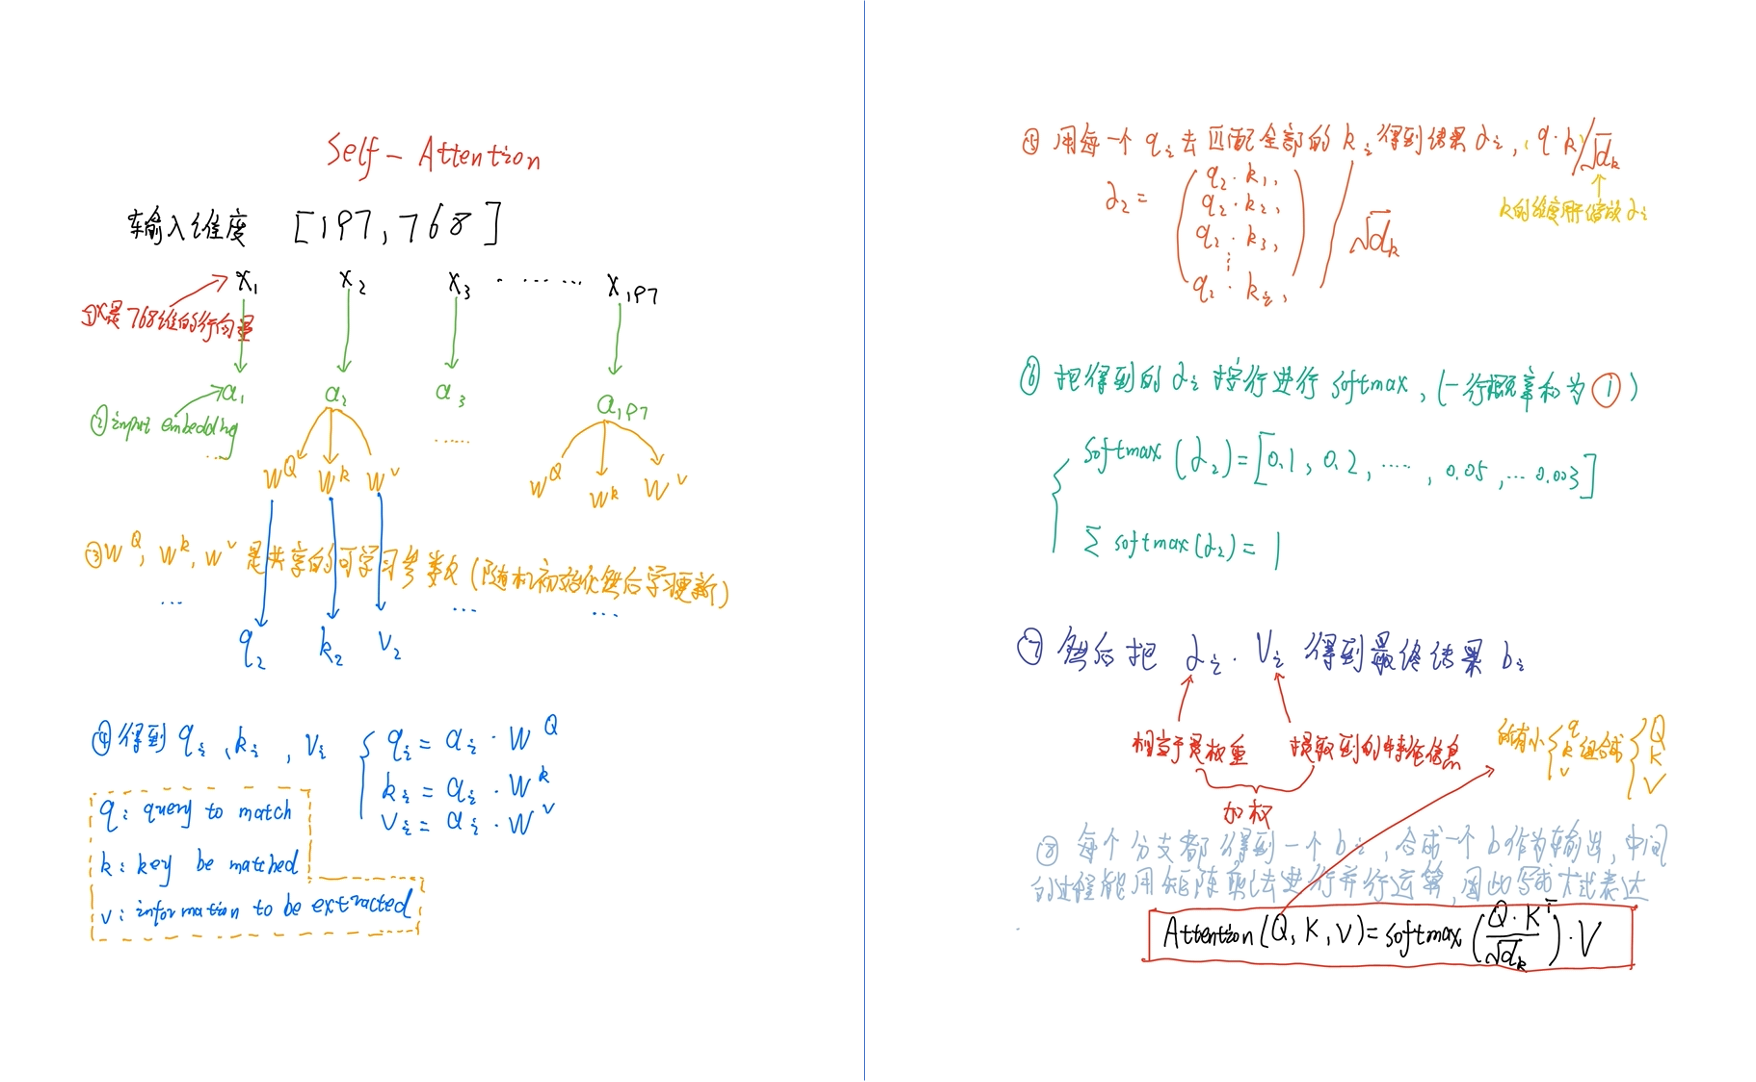

$$
Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V
$$

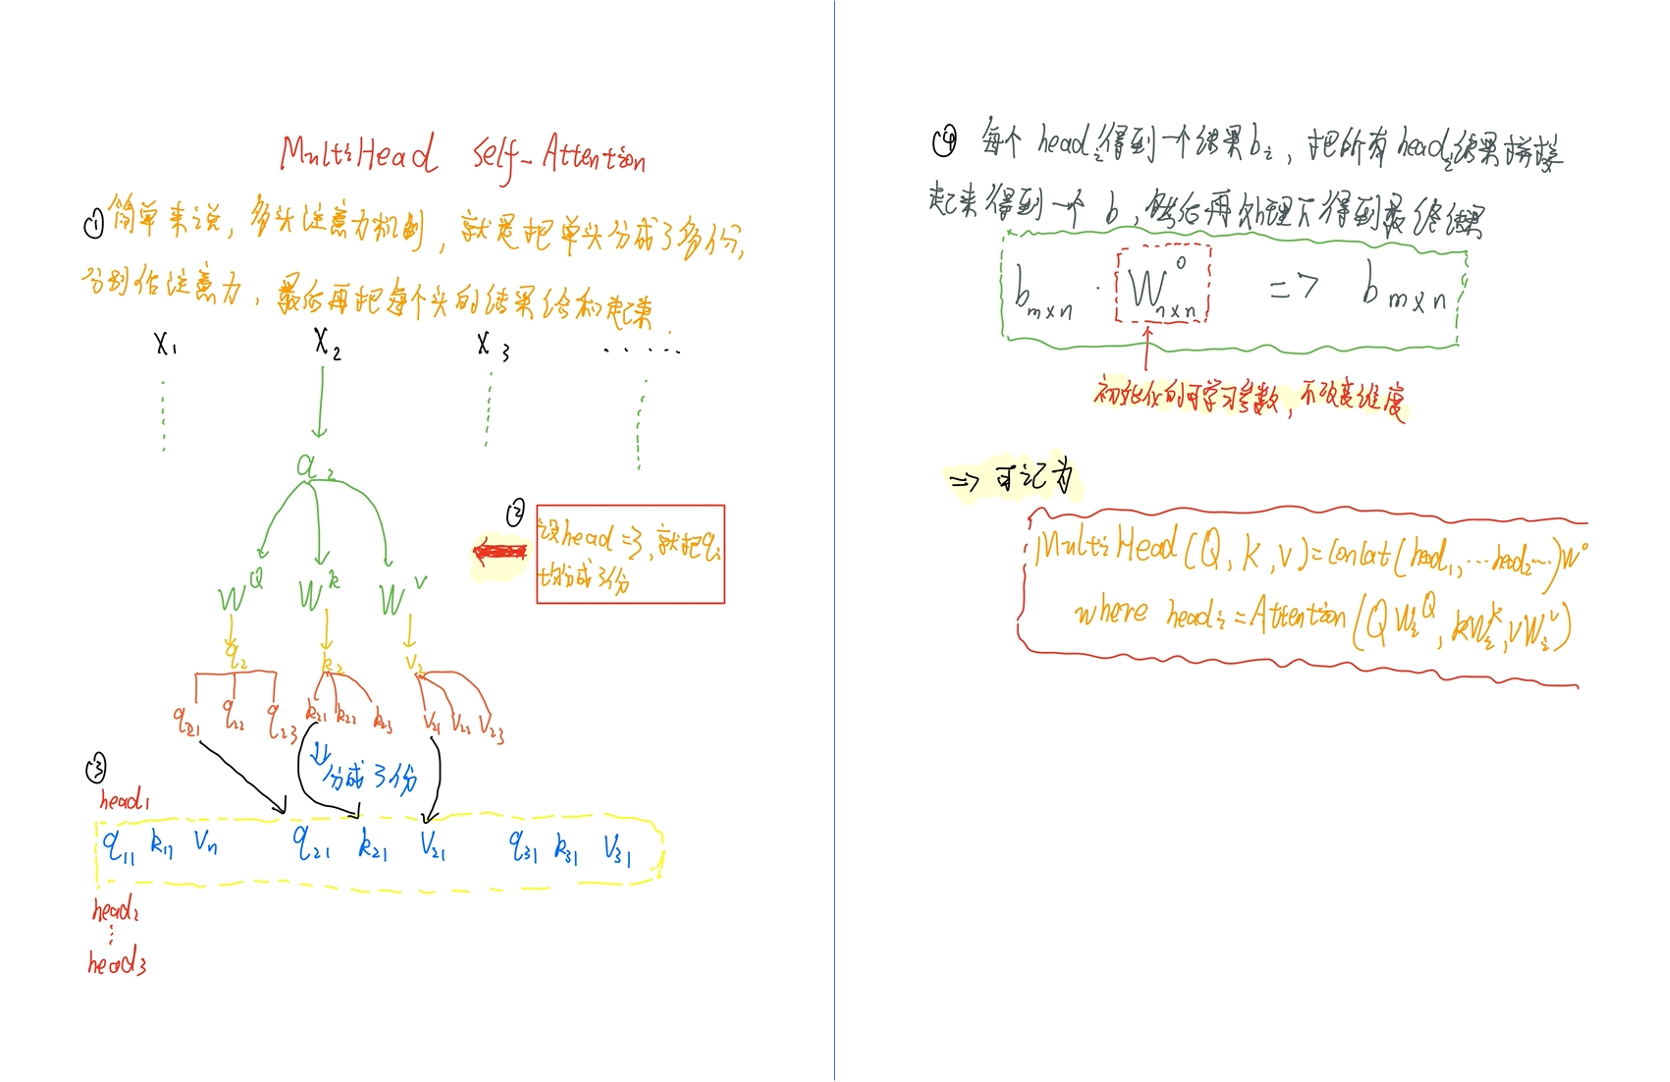

$$
MultiHead(Q, K, V) = Concat(head_1,..., head_h)W^O \\
where \, head_i = Attention(QW_i^Q, KW_i^K, VW_i^V)
$$

注意力机制细节

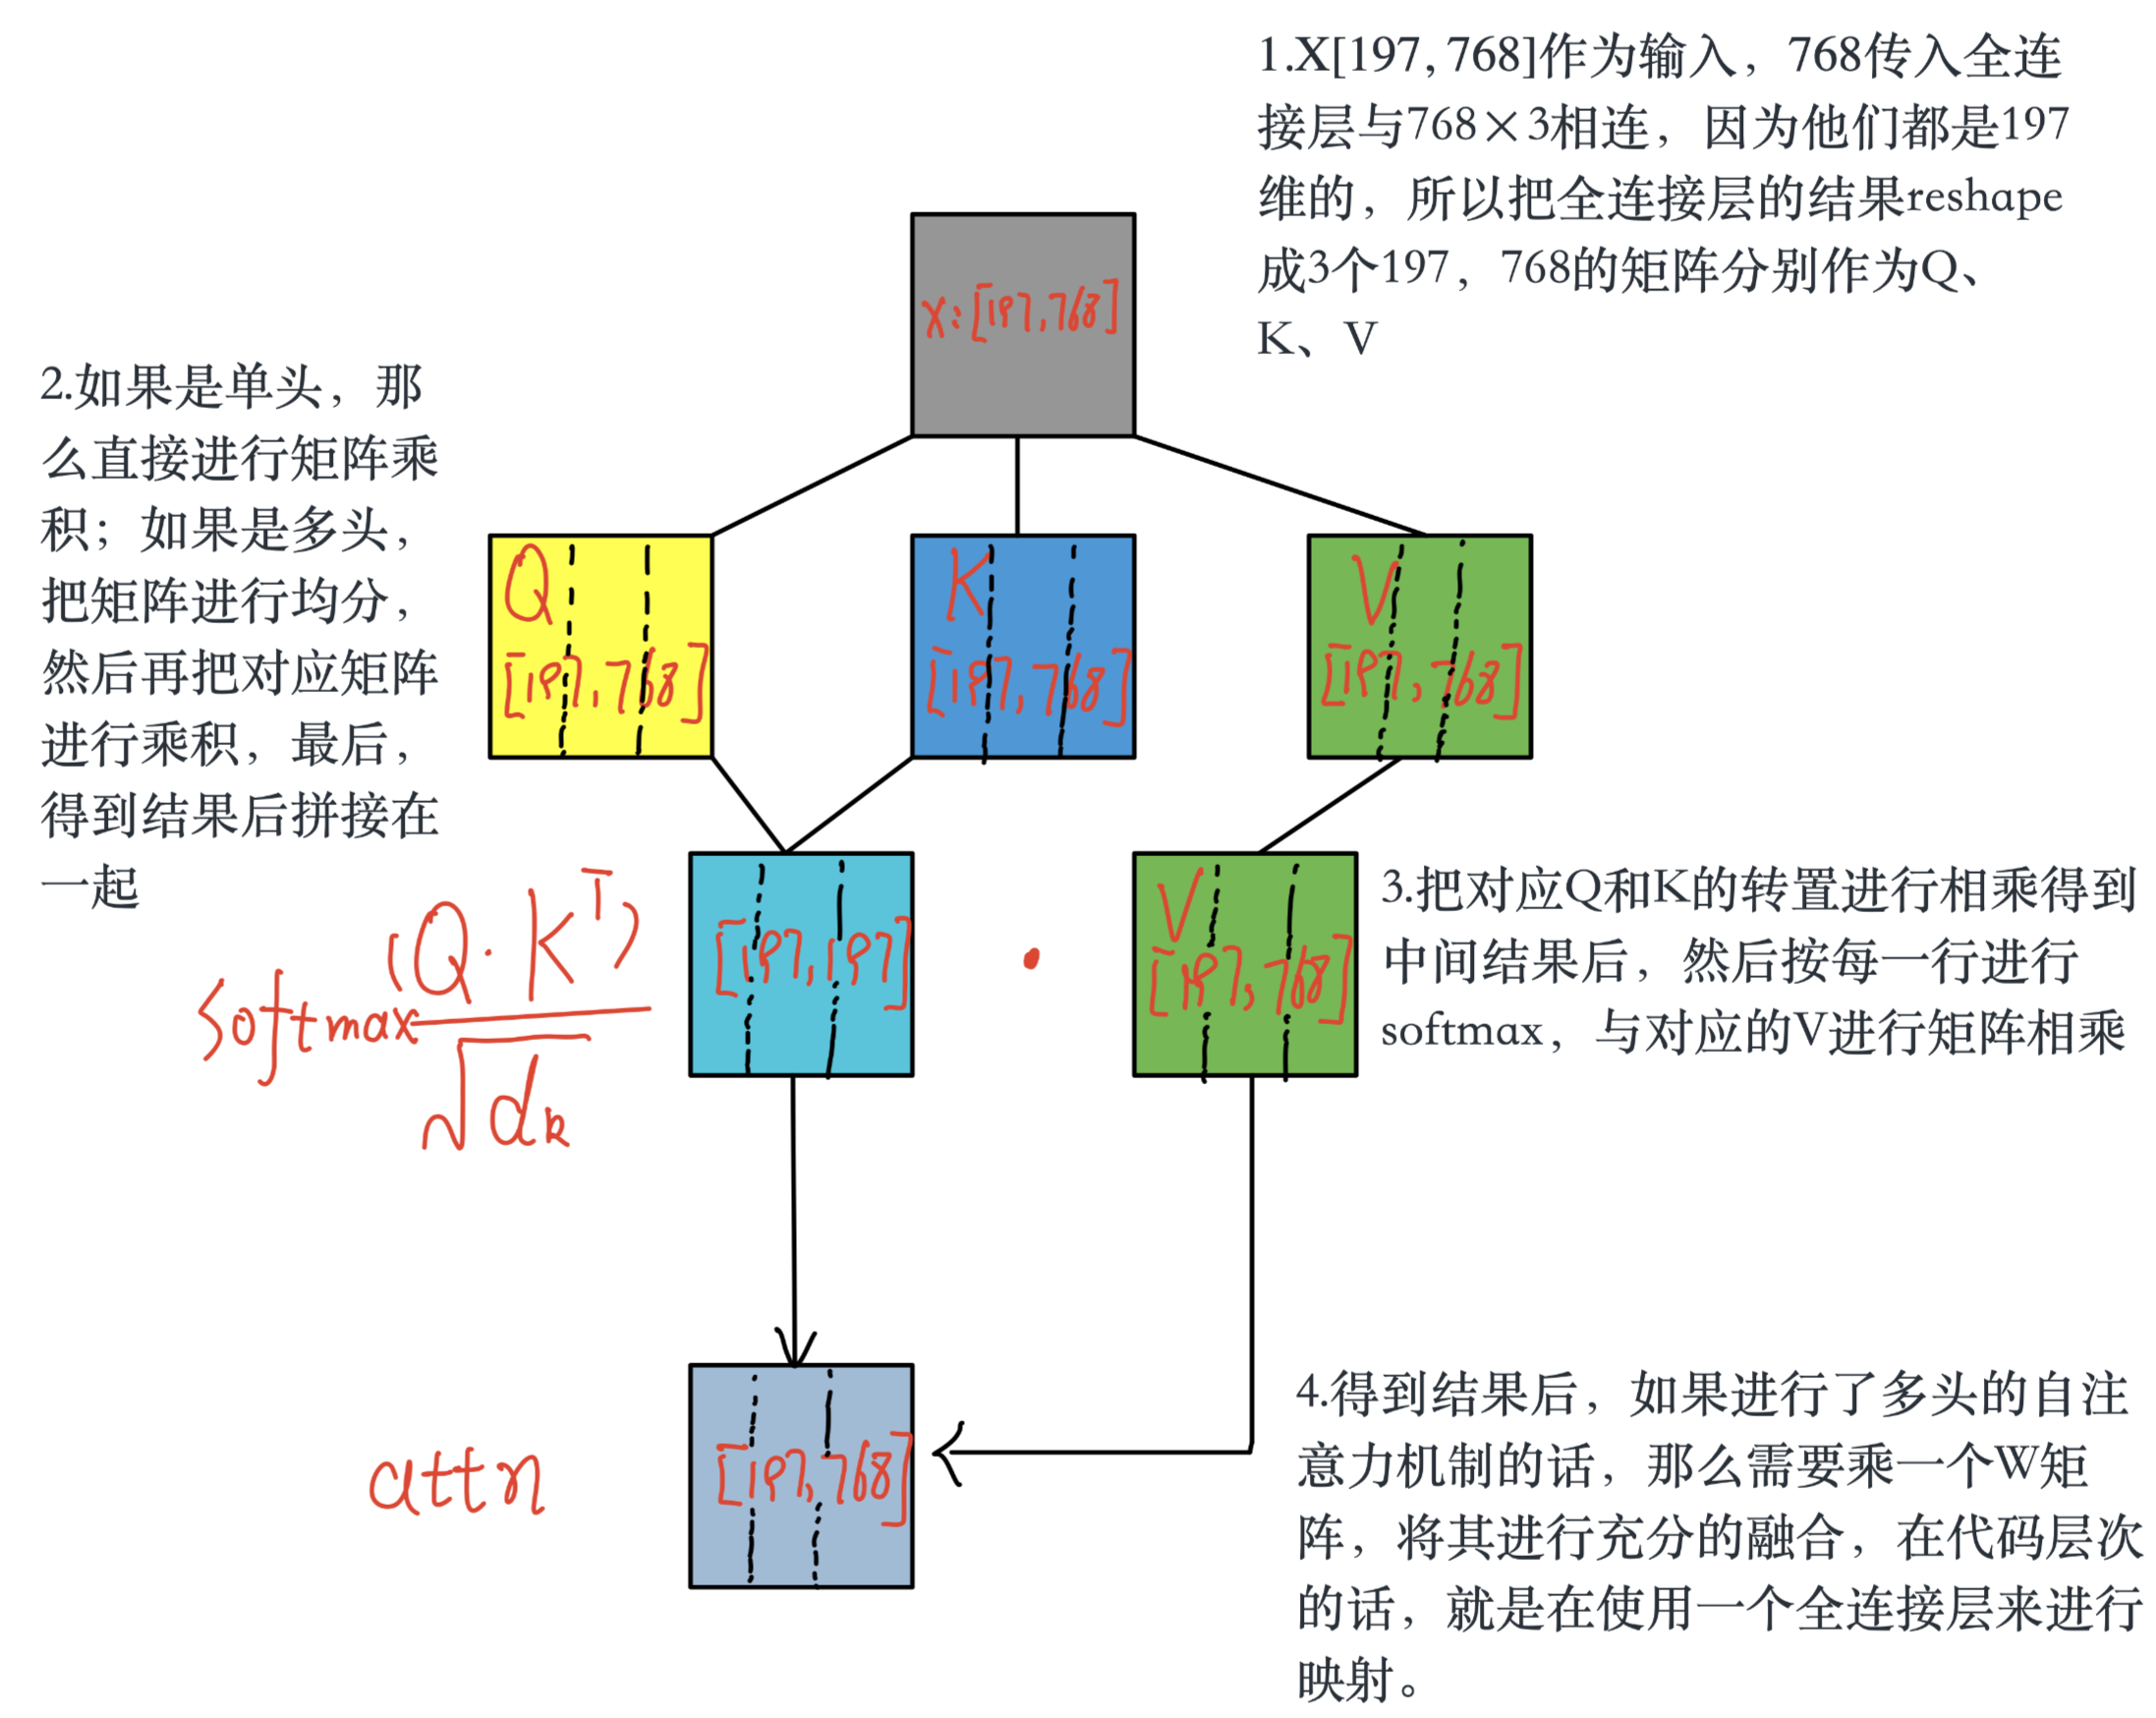

### 第五部分：MLP Head
分类头的意思就是：特征提取工作已经全部完成，现在你要做分类就加上对应的操作。（同CNN特征提取层后的Linear层+Softmax进行分类预测）。

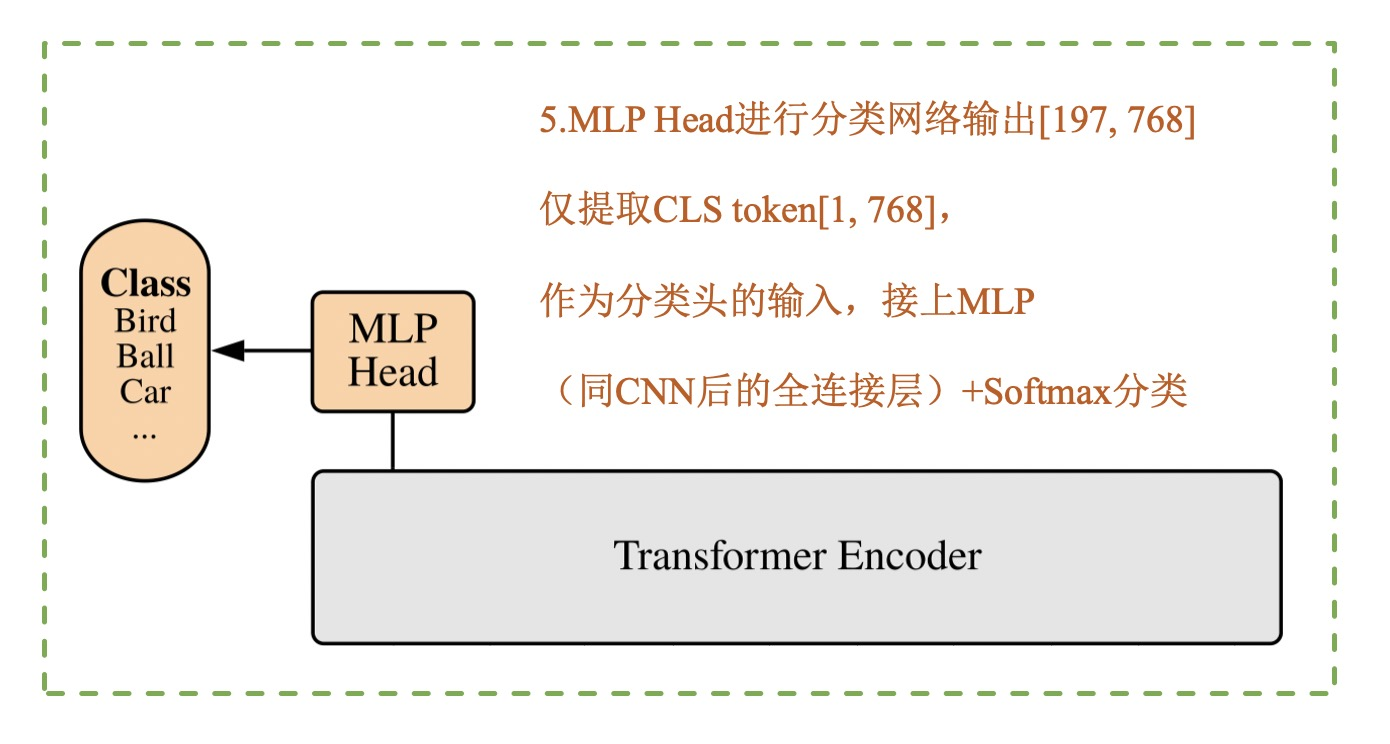

整个Encoder的输出为[197, 768]我们仅仅保留最前面的CLS token作为全连接的输入[1, 768]，然后接上全连接层及分类数n_class，使用交叉熵损失函数计算损失，反向传播更新网络的权重和参数。

原文分类头的细节

- 分类头在预训练时由含有一个隐含层的MLP实现，微调时由简单的线性层来实现

- 在将ViT模型迁移到另一个数据集时，我们移除整个head（两个全连接层-隐含层和输出层），并将其替换为一个简单的、全零初始化的线性层，输出的类别数为目标数据集的类别数

- 我们发现这样初始化比简单地重新初始化最后一层要更加具有鲁棒性


In [ ]:
"""
original code from rwightman:
https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
"""

import os
from collections import OrderedDict
from functools import partial

import torch
import torch.nn as nn

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


def drop_path(x, drop_prob: float = 0.0, training: bool = False):
    """
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0.0 or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (
        x.ndim - 1
    )  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """

    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class PatchEmbed(nn.Module):
    """
    2D Image to Patch Embedding
    """

    def __init__(
        self, img_size=224, patch_size=16, in_c=3, embed_dim=768, norm_layer=None
    ):
        super().__init__()
        img_size = (img_size, img_size)
        patch_size = (patch_size, patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        self.proj = nn.Conv2d(
            in_c, embed_dim, kernel_size=patch_size, stride=patch_size
        )
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        assert (
            H == self.img_size[0] and W == self.img_size[1]
        ), f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."

        # flatten: [B, C, H, W] -> [B, C, HW]
        # transpose: [B, C, HW] -> [B, HW, C]
        x = self.proj(x).flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x


class Attention(nn.Module):
    def __init__(
        self,
        dim,  # 输入token的dim
        num_heads=8,
        qkv_bias=False,
        qk_scale=None,
        attn_drop_ratio=0.0,
        proj_drop_ratio=0.0,
    ):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim**-0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop_ratio)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop_ratio)

    def forward(self, x):
        # [batch_size, num_patches + 1, total_embed_dim]
        B, N, C = x.shape

        # qkv(): -> [batch_size, num_patches + 1, 3 * total_embed_dim]
        # reshape: -> [batch_size, num_patches + 1, 3, num_heads, embed_dim_per_head]
        # permute: -> [3, batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        print("输入维度:", self.qkv(x).shape)
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.num_heads, C // self.num_heads)
            .permute(2, 0, 3, 1, 4)
        )
        # [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )  # make torchscript happy (cannot use tensor as tuple)
        print("q的维度:", q.shape)

        # transpose: -> [batch_size, num_heads, embed_dim_per_head, num_patches + 1]
        # @: multiply -> [batch_size, num_heads, num_patches + 1, num_patches + 1]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        print("缩放尺度:", self.scale)
        print("k的维度:", k.shape)
        print("k转置的维度:", k.transpose(-2, -1).shape)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        print("注意力权重的维度: ", attn.shape)

        # @: multiply -> [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        # transpose: -> [batch_size, num_patches + 1, num_heads, embed_dim_per_head]
        # reshape: -> [batch_size, num_patches + 1, total_embed_dim]
        print("v的权重: ", v.shape)
        print("注意力权重*v的维度: ", (attn @ v).shape)
        print("注意力结果的维度: ", (attn @ v).transpose(1, 2).shape)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        print("映射后encode输出维度: ", x.shape)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Mlp(nn.Module):
    """
    MLP as used in Vision Transformer, MLP-Mixer and related networks
    """

    def __init__(
        self,
        in_features,
        hidden_features=None,
        out_features=None,
        act_layer=nn.GELU,
        drop=0.0,
    ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Block(nn.Module):
    def __init__(
        self,
        dim,
        num_heads,
        mlp_ratio=4.0,
        qkv_bias=False,
        qk_scale=None,
        drop_ratio=0.0,
        attn_drop_ratio=0.0,
        drop_path_ratio=0.0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
    ):
        super(Block, self).__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop_ratio=attn_drop_ratio,
            proj_drop_ratio=drop_ratio,
        )
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = (
            DropPath(drop_path_ratio) if drop_path_ratio > 0.0 else nn.Identity()
        )
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(
            in_features=dim,
            hidden_features=mlp_hidden_dim,
            act_layer=act_layer,
            drop=drop_ratio,
        )

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=224,
        patch_size=16,
        in_c=3,
        num_classes=1000,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        representation_size=None,
        distilled=False,
        drop_ratio=0.0,
        attn_drop_ratio=0.0,
        drop_path_ratio=0.0,
        embed_layer=PatchEmbed,
        norm_layer=None,
        act_layer=None,
    ):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_c (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            qk_scale (float): override default qk scale of head_dim ** -0.5 if set
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            distilled (bool): model includes a distillation token and head as in DeiT models
            drop_ratio (float): dropout rate
            attn_drop_ratio (float): attention dropout rate
            drop_path_ratio (float): stochastic depth rate
            embed_layer (nn.Module): patch embedding layer
            norm_layer: (nn.Module): normalization layer
        """
        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = (
            embed_dim  # num_features for consistency with other models
        )
        self.num_tokens = 2 if distilled else 1
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.patch_embed = embed_layer(
            img_size=img_size, patch_size=patch_size, in_c=in_c, embed_dim=embed_dim
        )
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dist_token = (
            nn.Parameter(torch.zeros(1, 1, embed_dim)) if distilled else None
        )
        self.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + self.num_tokens, embed_dim)
        )
        self.pos_drop = nn.Dropout(p=drop_ratio)

        dpr = [
            x.item() for x in torch.linspace(0, drop_path_ratio, depth)
        ]  # stochastic depth decay rule
        self.blocks = nn.Sequential(
            *[
                Block(
                    dim=embed_dim,
                    num_heads=num_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    qk_scale=qk_scale,
                    drop_ratio=drop_ratio,
                    attn_drop_ratio=attn_drop_ratio,
                    drop_path_ratio=dpr[i],
                    norm_layer=norm_layer,
                    act_layer=act_layer,
                )
                for i in range(depth)
            ]
        )
        self.norm = norm_layer(embed_dim)

        # Representation layer
        if representation_size and not distilled:
            self.has_logits = True
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(
                OrderedDict(
                    [
                        ("fc", nn.Linear(embed_dim, representation_size)),
                        ("act", nn.Tanh()),
                    ]
                )
            )
        else:
            self.has_logits = False
            self.pre_logits = nn.Identity()

        # Classifier head(s)
        self.head = (
            nn.Linear(self.num_features, num_classes)
            if num_classes > 0
            else nn.Identity()
        )
        self.head_dist = None
        if distilled:
            self.head_dist = (
                nn.Linear(self.embed_dim, self.num_classes)
                if num_classes > 0
                else nn.Identity()
            )

        # Weight init
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        if self.dist_token is not None:
            nn.init.trunc_normal_(self.dist_token, std=0.02)

        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(_init_vit_weights)

    def forward_features(self, x):
        # [B, C, H, W] -> [B, num_patches, embed_dim]
        x = self.patch_embed(x)  # [B, 196, 768]
        # [1, 1, 768] -> [B, 1, 768]
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        if self.dist_token is None:
            x = torch.cat((cls_token, x), dim=1)  # [B, 197, 768]
        else:
            x = torch.cat(
                (cls_token, self.dist_token.expand(x.shape[0], -1, -1), x), dim=1
            )

        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)
        if self.dist_token is None:
            return self.pre_logits(x[:, 0])
        else:
            return x[:, 0], x[:, 1]

    def forward(self, x):
        x = self.forward_features(x)
        if self.head_dist is not None:
            x, x_dist = self.head(x[0]), self.head_dist(x[1])
            if self.training and not torch.jit.is_scripting():
                # during inference, return the average of both classifier predictions
                return x, x_dist
            else:
                return (x + x_dist) / 2
        else:
            x = self.head(x)
        return x


def _init_vit_weights(m):
    """
    ViT weight initialization
    :param m: module
    """
    if isinstance(m, nn.Linear):
        nn.init.trunc_normal_(m.weight, std=0.01)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode="fan_out")
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        nn.init.zeros_(m.bias)
        nn.init.ones_(m.weight)


def vit_base_patch16_224(num_classes: int = 1000):
    """
    ViT-Base model (ViT-B/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-1k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    链接: https://pan.baidu.com/s/1zqb08naP0RPqqfSXfkB2EA  密码: eu9f
    """
    model = VisionTransformer(
        img_size=224,
        patch_size=16,
        embed_dim=768,
        depth=12,
        num_heads=3,
        representation_size=None,
        num_classes=num_classes,
    )
    return model


def vit_base_patch16_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Base model (ViT-B/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_patch16_224_in21k-e5005f0a.pth
    """
    model = VisionTransformer(
        img_size=224,
        patch_size=16,
        embed_dim=768,
        depth=12,
        num_heads=12,
        representation_size=768 if has_logits else None,
        num_classes=num_classes,
    )
    return model


def vit_base_patch32_224(num_classes: int = 1000):
    """
    ViT-Base model (ViT-B/32) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-1k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    链接: https://pan.baidu.com/s/1hCv0U8pQomwAtHBYc4hmZg  密码: s5hl
    """
    model = VisionTransformer(
        img_size=224,
        patch_size=32,
        embed_dim=768,
        depth=12,
        num_heads=12,
        representation_size=None,
        num_classes=num_classes,
    )
    return model


def vit_base_patch32_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Base model (ViT-B/32) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_patch32_224_in21k-8db57226.pth
    """
    model = VisionTransformer(
        img_size=224,
        patch_size=32,
        embed_dim=768,
        depth=12,
        num_heads=12,
        representation_size=768 if has_logits else None,
        num_classes=num_classes,
    )
    return model


def vit_large_patch16_224(num_classes: int = 1000):
    """
    ViT-Large model (ViT-L/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-1k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    链接: https://pan.baidu.com/s/1cxBgZJJ6qUWPSBNcE4TdRQ  密码: qqt8
    """
    model = VisionTransformer(
        img_size=224,
        patch_size=16,
        embed_dim=1024,
        depth=24,
        num_heads=16,
        representation_size=None,
        num_classes=num_classes,
    )
    return model


def vit_large_patch16_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Large model (ViT-L/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_patch16_224_in21k-606da67d.pth
    """
    model = VisionTransformer(
        img_size=224,
        patch_size=16,
        embed_dim=1024,
        depth=24,
        num_heads=16,
        representation_size=1024 if has_logits else None,
        num_classes=num_classes,
    )
    return model


def vit_large_patch32_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Large model (ViT-L/32) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_patch32_224_in21k-9046d2e7.pth
    """
    model = VisionTransformer(
        img_size=224,
        patch_size=32,
        embed_dim=1024,
        depth=24,
        num_heads=16,
        representation_size=1024 if has_logits else None,
        num_classes=num_classes,
    )
    return model


def vit_huge_patch14_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Huge model (ViT-H/14) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    NOTE: converted weights not currently available, too large for github release hosting.
    """
    model = VisionTransformer(
        img_size=224,
        patch_size=14,
        embed_dim=1280,
        depth=32,
        num_heads=16,
        representation_size=1280 if has_logits else None,
        num_classes=num_classes,
    )
    return model


if __name__ == "__main__":
    model = vit_base_patch16_224(num_classes=9)
    inputs = torch.rand(1, 3, 224, 224)
    outputs = model(inputs)
    print(model)
    print(outputs.shape)

# Vision Transformer (ViT)

ViT适用于大数据集的预训练，在小样本数据集上效果不佳。

This is a PyTorch implementation of the paper An Image Is Worth 16x16 Words: Transformers For Image Recognition At Scale.

Vision transformer applies a pure transformer to images without any convolution layers. They split the image into patches and apply a transformer on patch embeddings. Patch embeddings are generated by applying a simple linear transformation to the flattened pixel values of the patch. Then a standard transformer encoder is fed with the patch embeddings, along with a classification token [CLS] . The encoding on the [CLS] token is used to classify the image with an MLP.

When feeding the transformer with the patches, learned positional embeddings are added to the patch embeddings, because the patch embeddings do not have any information about where that patch is from. The positional embeddings are a set of vectors for each patch location that get trained with gradient descent along with other parameters.

ViTs perform well when they are pre-trained on large datasets. The paper suggests pre-training them with an MLP classification head and then using a single linear layer when fine-tuning. The paper beats SOTA with a ViT pre-trained on a 300 million image dataset. They also use higher resolution images during inference while keeping the patch size the same. The positional embeddings for new patch locations are calculated by interpolating learning positional embeddings.

Here's an experiment that trains ViT on CIFAR-10. This doesn't do very well because it's trained on a small dataset. It's a simple experiment that anyone can run and play with ViTs.

![ViT](./vit-pytorch-main/images/vit.gif)

In [1]:
import torch
from torch import nn


class PatchEmbeddings(nn.Module):
    """
    获取图像块的嵌入表示
    该方法将图像分割成大小相等的块，并对每个块中的展平像素进行线性变换。
    通过卷积层实现这一过程，因为这样更易于实现。
    """

    def __init__(
        self,
        in_channels: int,
        d_model: int,
        patch_size: int,
        num_patches: int,
        dropout: float,
    ):
        """
        初始化PatchEmbeddings类
        in_channels: 输入图像的通道数(如RGB图像为3)
        d_model: transformer embeddings size
        patch_size: 图像块的大小
        num_patches: 从图像中提取的块数
        dropout: 应用于每个块展平像素线性变换的dropout率
        """
        super().__init__()

        # 创建一个卷积层，其核大小和步长等于patch_size，等效于将图像分割成块并对每个块进行线性变换
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=d_model,
                kernel_size=patch_size,
                stride=patch_size,
            ),
            nn.Flatten(start_dim=2),
        )

        # 创建一个可学习的类标记（cls_token），用于表示整个序列的特征
        self.cls_token = nn.Parameter(
            torch.randn(size=(1, 1, d_model)), requires_grad=True
        )

        # 创建位置嵌入，用于表示每个图像块的位置信息
        self.pos_embedding = nn.Parameter(
            torch.randn(size=(1, num_patches + 1, d_model))
        )

        # 创建dropout层，用于在训练过程中随机丢弃一些神经元，以防止过拟合
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        前向传播函数
        x: 输入图像，形状为(batch_size, in_channels, height, width)
        """
        # 扩展cls_token以匹配输入的batch_size
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        # 应用卷积层和展平操作，然后调整维度顺序
        x = self.patcher(x).permute(0, 2, 1)
        # 将cls_token与图像块特征拼接
        x = torch.cat((x, cls_token), dim=1)
        # 添加位置嵌入
        x += self.pos_embedding
        # 应用dropout
        x = self.dropout(x)
        return x


class ViT(nn.Module):
    """
    The Vision Transformer (ViT) model
    """

    def __init__(
        self,
        in_channels: int,
        d_model: int,
        patch_size: int,
        num_patches: int,
        dropout: float,
        num_heads: int,
        activation,
        num_encoders: int,
        num_classes: int,
        classification=True,
    ):
        """
        初始化 Vision Transformer 模型
        :param in_channels: 输入通道数
        :param d_model: 模型维度
        :param patch_size: 每个 patch 的大小
        :param num_patches: patch 的数量
        :param dropout: dropout 比例
        :param num_heads: 多头注意力机制的头数
        :param activation: 激活函数
        :param num_encoders: 编码器层数
        :param num_classes: 分类数

        d_model 必须是 nhead 的整数倍，具体来说，每个头的维度应该是 d_model / nhead
        """
        super().__init__()
        self.classification = classification
        
        self.patch_embeddings = PatchEmbeddings(
            in_channels=in_channels,
            d_model=d_model,
            patch_size=patch_size,
            num_patches=num_patches,
            dropout=dropout,
        )

        # 定义一个Transformer编码器层
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            activation=activation,
            dropout=dropout,
            batch_first=True,
            norm_first=True,
        )
        # 定义一个Transformer编码器，包含多个编码器层
        self.encoder_layers = nn.TransformerEncoder(
            encoder_layer=encoder_layer, num_layers=num_encoders
        )
        # 定义一个多层感知机（MLP），用于分类任务
        self.MLP = nn.Sequential(
            nn.LayerNorm(normalized_shape=d_model),
            nn.Linear(in_features=d_model, out_features=num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        前向传播函数
        :param x: 输入张量
        :return: 输出张量
        """
        x = self.patch_embeddings(x)
        x = self.encoder_layers(x)
        # 0: the cls token
        x = self.MLP(x[:, 0, :]) if self.classification else x[:, 1:, :]
        return x

In [2]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms



class MINSTTrainDataset(Dataset):
    # 初始化方法，用于设置图像、标签和索引，以及定义图像变换
    def __init__(self, images, labels, indices):
        self.images = images
        self.labels = labels
        self.indices = indices
        self.transform = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize(0.5, 0.5),
            ]
        )

    # 返回数据集的长度
    def __len__(self):
        return len(self.images)

    # 根据索引获取图像、标签和索引，并应用变换
    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28).astype(np.uint8)
        label = self.labels[idx]
        index = self.indices[idx]
        image = self.transform(image)
        return {"image": image, "label": label, "index": index}


class MINSTValDataset(Dataset):

    def __init__(self, images, labels, indices):
        # 初始化图像、标签和索引
        self.images = images
        self.labels = labels
        self.indices = indices
        # 定义图像变换
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(0.5, 0.5),
            ]
        )
    
    def __len__(self):
        # 返回图像数量
        return len(self.images)
    
    def __getitem__(self, idx):
        # 获取指定索引的图像、标签和索引
        image = self.images[idx].reshape(28, 28).astype(np.uint8)
        label = self.labels[idx]
        index = self.indices[idx]
        # 应用图像变换
        image = self.transform(image)
        return {"image": image, "label": label, "index": index}


class MINSTSubmissionDataset(Dataset):
    def __init__(self, images, indices):
        self.images = images
        self.indices = indices
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(0.5, 0.5),
            ]
        )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28).astype(np.uint8)
        index = self.indices[idx]
        image = self.transform(image)
        return {"image": image, "index": index}

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

def get_loaders(train_df_dir, test_df_dir, submission_df_dir, batch_size):
    # 定义一个函数用于获取数据加载器
    # 参数包括训练集路径、测试集路径、提交数据集路径和批大小

    train_df = pd.read_csv(train_df_dir)  # 从训练集路径读取数据
    test_df = pd.read_csv(test_df_dir)  # 从测试集路径读取数据
    submission_df = pd.read_csv(submission_df_dir)  # 从提交数据集路径读取数据

    train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=22)  # 将训练集分割为训练集和验证集

    train_dataset = MINSTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)  # 创建训练数据集
    val_dataset = MINSTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)  # 创建验证数据集
    test_dataset = MINSTSubmissionDataset(test_df.iloc[:, 1:].values.astype(np.uint8), test_df.index.values)  # 创建测试数据集

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # 创建训练数据加载器
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # 创建验证数据加载器
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # 创建测试数据加载器

    return train_dataloader, val_dataloader, test_dataloader  # 返回训练数据加载器、验证数据加载器和测试数据加载器
    

In [8]:
import torch
from torch import nn
from torch import optim
import timeit
from tqdm import tqdm


# 超参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 根据GPU是否可用选择设备
epochs = 50  # 训练轮数
batch_size = 2  # 批处理大小
train_df_dir = "./datasets/vit/train.csv"  # 训练数据集路径
test_df_dir = "./datasets/vit/test.csv"  # 测试数据集路径
submission_df_dir = "./datasets/vit/sample_submission.csv"  # 提交样本数据集路径
learning_rate = 0.001  # 学习率

# 模型参数
in_channels = 1  # 输入通道数
image_size = 28  # 图像尺寸
patch_size = 4  # 图像切分的patch大小
embeddin_dim = (patch_size**2) * in_channels  # 嵌入维度
num_patches = (image_size // patch_size) ** 2  # patch数量
dropout = 0.001  # dropout率

num_heads = 8  # 注意力头的数量
activation = "gelu"  # 激活函数
num_encoders = 768  # 编码器的数量
num_classes = 10  # 分类类别数量

learning_rate = 1e-4  # 学习率
adam_weight_decay = 0  # Adam优化器的权重衰减
adam_betas = (0.9, 0.999)  # Adam优化器的beta参数

# 获取数据加载器
train_dataloader, val_dataloader, test_dataloader = get_loaders(
    train_df_dir, test_df_dir, submission_df_dir, batch_size
)

# 初始化ViT模型
model = ViT(
    in_channels,
    embeddin_dim,
    patch_size,
    num_patches,
    dropout,
    num_heads,
    activation,
    num_encoders,
    num_classes,
).to(device)

# 定义交叉熵损失函数和Adam优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate,
    betas=adam_betas,
    weight_decay=adam_weight_decay,
)

start = timeit.default_timer()  # 记录起始时间

# 开始训练循环
for epoch in range(epochs):
    model.train()  # 设置模型为训练模式
    train_labels = []  # 存储训练集标签
    train_preds = []  # 存储训练集预测结果
    train_running_loss = 0.0  # 记录训练过程中损失函数值

    # 遍历训练集数据
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)  # 模型前向传播
        y_pred_label = torch.argmax(y_pred, dim=1)  # 获取预测结果

        train_labels.extend(label.cpu().detach())  # 存储标签
        train_preds.extend(y_pred_label.cpu().detach())  # 存储预测结果

        loss = criterion(y_pred, label)  # 计算损失函数
        optimizer.zero_grad()  # 梯度清零
        loss.backward()  # 反向传播计算梯度
        optimizer.step()  # 更新模型参数

        train_running_loss += loss.item()  # 累积损失函数值

    train_loss = train_running_loss / (idx + 1)  # 计算平均训练损失

    model.eval()  # 设置模型为评估模式
    val_labels = []  # 存储验证集标签
    val_preds = []  # 存储验证集预测结果
    val_running_loss = 0  # 记录验证过程中损失函数值
    with torch.no_grad():
        # 遍历验证集数据
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)
            y_pred = model(img)  # 模型前向传播
            y_pred_label = torch.argmax(y_pred, dim=1)  # 获取预测结果

            val_labels.extend(label.cpu().detach())  # 存储标签
            val_preds.extend(y_pred_label.cpu().detach())  # 存储预测结果

            loss = criterion(y_pred, label)  # 计算损失函数
            val_running_loss += loss.item()  # 累积损失函数值
    val_loss = val_running_loss / (idx + 1)  # 计算平均验证损失

    # 打印当前轮训练和验证结果
    print("-" * 30)
    print(f"Train Loss Epoch {epoch+1} : {train_loss:.4f}")
    print(f"Val Loss Epoch {epoch+1} : {val_loss:.4f}")
    # 计算并打印当前轮训练和验证集的准确率
    print(
        f"Train Accuracy EPOCH {epoch + 1}: {sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}"
    )
    print(
        f"Val Accuracy EPOCH {epoch + 1}: {sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}"
    )
    print("-" * 30)

stop = timeit.default_timer()  # 记录结束时间
print(f"Training Time:{stop - start:.2f}s")  # 打印训练耗时

/home/vtchen/miniconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
  0%|          | 1/18900 [00:05<30:24:20,  5.79s/it]


KeyboardInterrupt: 